
# Applying Resnet18 on CIFAR10 Dataset.

## Importing the required libraries

In [24]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from math import ceil


In [25]:
# checking if the gpu is connected or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4723405776582647182
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4840685568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14506692693563554614
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [26]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [27]:
n = 3
version = 1
depth = n * 6 + 2
model_type = 'ResNet%dv%d' % (depth, version)
print("Model we are using is of type",model_type)

Model we are using is of type ResNet20v1


In [28]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [29]:
# Input image dimensions.
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [30]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [31]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [32]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [33]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [34]:
# we will decrease our learning rate as the number of epochs increases 

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [35]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [36]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [37]:
model = resnet_v1(input_shape=input_shape, depth=depth)

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


In [39]:
model.summary()
print(model_type)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv2d_23 

In [40]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [41]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

## Now we will try to use Cutout and Random Eraser in our data
### Refer --> https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

In [42]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [43]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
# set input mean to 0 over the dataset
featurewise_center=False,
# set each sample mean to 0
samplewise_center=False,
# divide inputs by std of dataset
featurewise_std_normalization=False,
# divide each input by its std
samplewise_std_normalization=False,
        # apply ZCA whitening
zca_whitening=False,
        # epsilon for ZCA whitening
zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
rotation_range=0,
        # randomly shift images horizontally
width_shift_range=0.1,
        # randomly shift images vertically
height_shift_range=0.1,
        # set range for random shear
shear_range=0.,
        # set range for random zoom
zoom_range=0.,
        # set range for random channel shifts
channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
fill_mode='nearest',
        # value used for fill_mode = "constant"
cval=0.,
        # randomly flip images
horizontal_flip=True,
        # randomly flip images
vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
rescale=None,
        # set function that will be applied on each input
preprocessing_function=get_random_eraser(v_l=0, v_h=1),
        # image data format, either "channels_first" or "channels_last"
data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
validation_split=0.0)

Using real-time data augmentation.


In [44]:
# Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [77]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
validation_data=(x_test, y_test),epochs=epochs, verbose=1, workers=4,callbacks=callbacks,steps_per_epoch=ceil(x_train.shape[0] / batch_size))

Epoch 1/50
Learning rate:  0.001
1563/1563 [==============================] - 39s 25ms/step - loss: 1.6801 - acc: 0.4472 - val_loss: 1.7122 - val_acc: 0.4850

Epoch 00001: val_acc improved from -inf to 0.48500, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.001.h5
Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3323 - acc: 0.5808 - val_loss: 1.2364 - val_acc: 0.6239

Epoch 00002: val_acc improved from 0.48500 to 0.62390, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.002.h5
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 33s 21ms/step - loss: 1.1610 - acc: 0.6483 - val_loss: 1.0790 - val_acc: 0.6773

Epoch 00003: val_acc improved from 0.62390 to 0.67730, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.003.h5
Epoch 4/50
Learning rate:  0.001
1563/1563 

Learning rate:  1e-05
1563/1563 [==============================] - 137s 88ms/step - loss: 0.5225 - acc: 0.8841 - val_loss: 0.5372 - val_acc: 0.8797

Epoch 00030: val_acc improved from 0.87940 to 0.87970, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.030.h5
Epoch 31/50
Learning rate:  1e-05
1563/1563 [==============================] - 137s 88ms/step - loss: 0.5189 - acc: 0.8843 - val_loss: 0.5354 - val_acc: 0.8805

Epoch 00031: val_acc improved from 0.87970 to 0.88050, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.031.h5
Epoch 32/50
Learning rate:  1e-06
1563/1563 [==============================] - 137s 88ms/step - loss: 0.5191 - acc: 0.8834 - val_loss: 0.5334 - val_acc: 0.8813

Epoch 00032: val_acc improved from 0.88050 to 0.88130, saving model to C:\Users\RASHU TYAGI\EIP 4 Phase 1\Session 4\saved_models\cifar10_ResNet20v1_model.032.h5
Epoch 33/50
Learning rate:  1e-06
1563/1563 [=

In [45]:
# load and evaluate a saved model because we have already trained our model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('saved_models/cifar10_ResNet20v1_model.040.h5')
# summarize model.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_44 

In [ ]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## GradCAM on applying model.

In [46]:
!pip install opencv-python

In [47]:
from keras.preprocessing import image
import numpy as np
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [48]:
from skimage import io

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_44 

In [98]:
cat = io.imread("cat-hangover-red-cute-mackerel-tiger-sweet.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)



# Normalize data.


x = x.astype('float32') / 255
x = x.astype('float32') / 255


In [99]:
x

array([[[[ 1.18509796e-03,  1.12604385e-03,  1.15832372e-03],
         [ 9.08281421e-04,  8.95363337e-04,  9.27643210e-04],
         [ 5.23813884e-04,  5.57031948e-04,  7.43098848e-04],
         ...,
         [-9.37162666e-04, -1.96524401e-04,  4.35524795e-04],
         [-1.42928108e-03, -9.80838086e-04, -8.73510216e-05],
         [-1.32163020e-03, -1.05773169e-03, -2.58362215e-05]],

        [[ 6.46843459e-04,  7.41576310e-04,  8.19992332e-04],
         [-1.04481354e-03, -6.42506697e-04, -2.25759330e-04],
         [ 1.27737015e-03,  9.72256821e-04,  9.12264513e-04],
         ...,
         [-1.27549400e-03, -6.88642845e-04,  1.27950785e-04],
         [-1.41390238e-03, -1.10386778e-03,  4.92117942e-06],
         [-1.47541717e-03, -1.19613996e-03, -1.48865831e-04]],

        [[-4.75801673e-04, -3.19554005e-04, -1.04575211e-05],
         [ 1.53880811e-03,  1.29520951e-03,  1.11218763e-03],
         [ 1.75410986e-03,  1.60278345e-03,  1.55816996e-03],
         ...,
         [-1.44465978e-0

In [100]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

8


In [101]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 8, 8, 64)
(64,)


In [102]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(8, 8, 64)
(8, 8)


In [103]:
import cv2


In [104]:
heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)


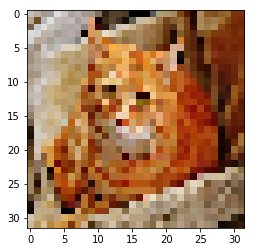

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

#from patches import cv2.imshow
#cv2.imshow('',cat)
#cv2.imshow('',superimposed_img)

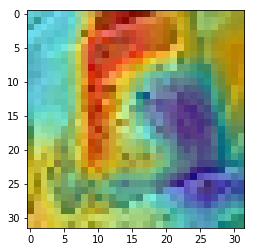

In [106]:
plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


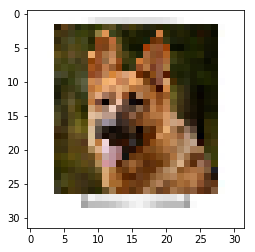

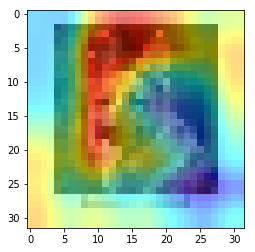

In [97]:
cat = io.imread("red-german-shepherd-dog-sandy-keeton.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

# Normalize data.
x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


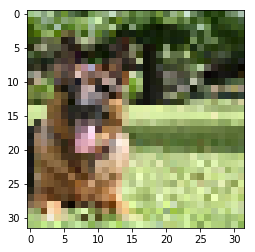

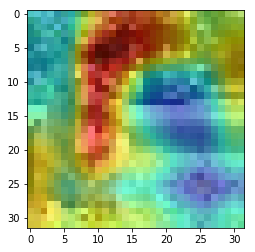

In [92]:
cat = io.imread("images.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)


x = preprocess_input(x)
# Normalize data.
x = x.astype('float32') / 255
x = x.astype('float32') / 255



preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


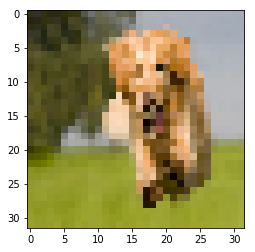

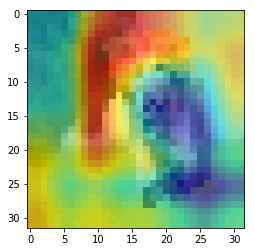

In [94]:
cat = io.imread("puppytraining7.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255


preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


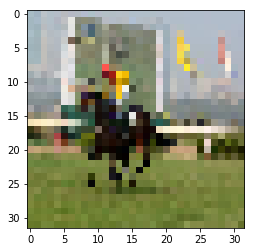

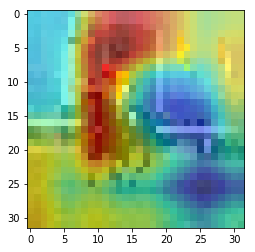

In [95]:
cat = io.imread("horse-edited.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


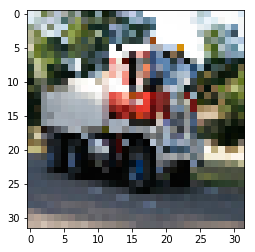

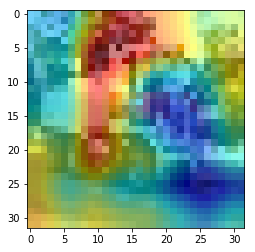

In [96]:
cat = io.imread("Truck_with_motion_blur.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


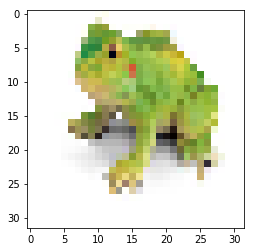

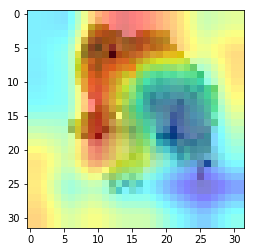

In [107]:
cat = io.imread("71OQaYbGtHL._SX355_.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

In [ ]:
flying_plane_190518

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


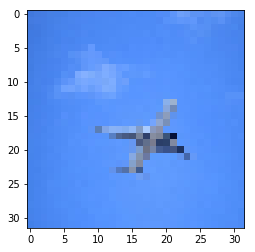

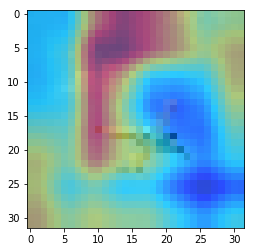

In [108]:
cat = io.imread("flying_plane_190518.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


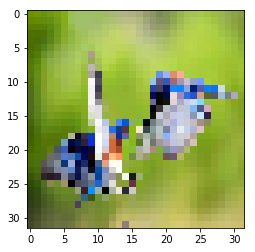

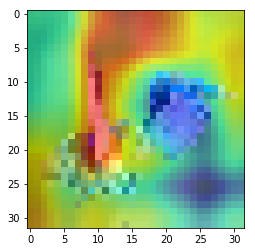

In [109]:
cat = io.imread("blue-birds.jpg.824x0_q71.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

8
(?, 8, 8, 64)
(64,)
(8, 8, 64)
(8, 8)


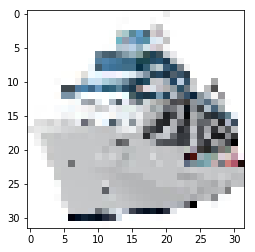

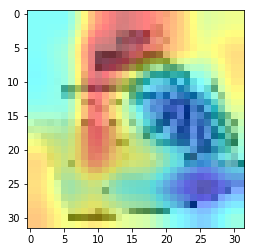

In [110]:
cat = io.imread("download.jpg")
cat= cv2.resize(cat, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(cat)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x = x.astype('float32') / 255
x = x.astype('float32') / 255

preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_63")

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (cat.shape[1], cat.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cat, 0.5, heatmap, 0.5, 0)

%matplotlib inline
import matplotlib.pyplot as plt
# load image using cv2....and do processing.
plt.imshow(cat)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

plt.imshow(superimposed_img)
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()